In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial, eval_genlaguerre
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD,adam
from diffractio import degrees, mm, nm, np, plt, sp, um
from diffractio.scalar_sources_XY import Scalar_source_XY
from skimage.measure import block_reduce
from tqdm import tqdm_notebook as tqdm

In [77]:
#Intensty of 2 superposed LG beams; a and b are complex numbers
def Intensity(l1,p1,l2,p2,a,b):

    w0 = 50.0;               # Beam waist
    k = 2*np.pi/532.0e-9;   # Wavenumber of light

    zR = k*w0**2.0/2;       

    z = 0.0;
    xx, yy = np.meshgrid(np.linspace(-100, 100), np.linspace(-100, 100));

    r = np.sqrt(xx**2 + yy**2);
    phi = np.arctan2(yy, xx);

    U00 = 1.0/(1 + 1j*z/zR) * np.exp(-r**2.0/w0**2/(1 + 1j*z/zR));
    w = w0 * np.sqrt(1.0 + z**2/zR**2);
    R = np.sqrt(2.0)*r/w;

    Lpl1=eval_genlaguerre(p1, l1, R**2, out=None) 
    Lpl2=eval_genlaguerre(p2, l2, R**2, out=None) 

    U1 = U00*R**l1*Lpl1*np.exp(1j*l1*phi)*np.exp(-1j*(2*p1 + l1 + 1)*np.arctan(z/zR))
    U2 = U00*R**l2*Lpl2*np.exp(1j*l2*phi)*np.exp(-1j*(2*p2 + l2 + 1)*np.arctan(z/zR))
    
    aa=a[0]+a[1]*1j
    bb=b[0]+b[1]*1j

    U=aa*U1+bb*U2
    
    return abs(U)**2




#LG beam intensity using diffractio library
def Intensity_diffractio(l1,p1,l2,p2,a,b):
    
    x0 = np.linspace(-1*mm, 1*mm, 512)
    y0 = np.linspace(-1*mm, 1*mm, 512)
    wavelength = 0.6238 * um

    u1 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
    u2 = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)
    
    u1.laguerre_beam(p=p1, l=l1, r0=(0 * um, 0 * um), w0=250 * um, z=0.01 * um)
    u2.laguerre_beam(p=p2, l=l2, r0=(0 * um, 0 * um), w0=250 * um, z=0.01 * um)
    
    u1.u = block_reduce(u1.u, block_size=(8,8), func=np.mean, cval=np.mean(u1.u))
    u2.u = block_reduce(u2.u, block_size=(8,8), func=np.mean, cval=np.mean(u2.u))
    
    aa=a[0]+a[1]*1j
    bb=b[0]+b[1]*1j

    return abs(aa*u1.u+bb*u2.u)**2





#Amplitude of superposed wave; output dimension: 50x50x2
def Amplitude(l,p,a):

    w0 = 200.0;               # Beam waist
    k = 2*np.pi/532.0e-9;   # Wavenumber of light

    zR = k*w0**2.0/2;       

    z = 0.0;
    xx, yy = np.meshgrid(np.linspace(-200, 200), np.linspace(-200, 200));

    r = np.sqrt(xx**2 + yy**2);
    phi = np.arctan2(yy, xx);

    U00 = 1.0/(1 + 1j*z/zR) * np.exp(-r**2.0/w0**2/(1 + 1j*z/zR));
    w = w0 * np.sqrt(1.0 + z**2/zR**2);
    R = np.sqrt(2.0)*r/w;

    
    Lpl=[]
    
    for i in range(len(l)):
        Lpl1=eval_genlaguerre(p[i], l[i], R**2, out=None)
        Lpl.append(Lpl1);

    UU=[]
    for i in range(len(Lpl)):
        U1 = U00*R**l[i]*Lpl[i]*np.exp(1j*l[i]*phi)*np.exp(-1j*(2*p[i] + l[i] + 1)*np.arctan(z/zR))
        UU.append(U1)
    
    
    #superposition of waves
    aa=a[0][0]+a[0][1]*1j;
    U=aa*UU[0]
    
    for i in range(1,len(UU)):
        aa=a[i][0]+a[i][1]*1j;
        U+=aa*UU[i]
        
        
    #seperate real and imag parts    
    
    res=[]
    for i in range(U.shape[0]):
        x=[]
        for j in range(U.shape[1]):
            y=[]
            r=np.real(U[i][j])
            im=np.imag(U[i][j])
            y.append(r),y.append(im)
            x.append(y)
        res.append(x)
        
    res=np.array(res)
    
    return res

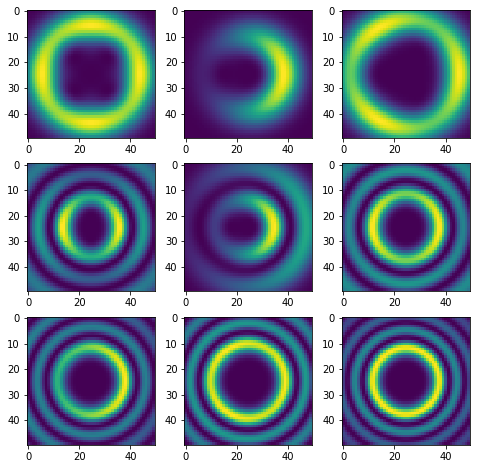

In [82]:

# superposed wave for random values of l1,p1,l2 and p2
I=[Intensity(1,0,5,0,[1,1],[1,1]),Intensity(3,0,2,0,[1,1],[1,1]),
    Intensity(6,0,3,0,[1,1],[1,1]),Intensity(4,2,2,1,[1,1],[1,1]),
    Intensity(3,1,2,1,[1,1],[1,1]),Intensity(5,2,3,0,[1,1],[1,1]),
    Intensity(6,3,5,1,[1,1],[1,1]),Intensity(7,3,4,1,[1,1],[1,1]),
    Intensity(7,5,7,4,[1,1],[1,1])]

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(0, columns*rows):
    img = I[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [105]:
X=[]
Y=[]


for i in tqdm(range(4000)):
    abb=[]
    for j in range(3):
        abb.append(np.random.uniform(-1,1,2))
        
    ab=[]
    for j in range(len(abb)):
        ab.append(abb[j][0])
        ab.append(abb[j][1])
        
    Y.append(ab)
    l=[1,2,3]
    p=[0,0,0]
    
    A=Amplitude(l,p,abb)
    
    X.append(A)
    
Y=np.array(Y)
X=np.array(X)
print(X.shape,Y.shape)


(4000, 50, 50, 2) (4000, 6)


In [106]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [107]:
model = Sequential()
model.add(Conv2D(50, kernel_size=2, activation='relu', input_shape=(50,50,2)))
model.add(Conv2D(25, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=None, padding="valid"))
model.add(Conv2D(15, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=None, padding="valid"))
model.add(Conv2D(5,kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=None, padding="valid"))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(6, activation='tanh'))

In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 49, 49, 50)        450       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 25)        5025      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 25)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 23, 23, 15)        1515      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 15)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 5)         305       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 5)           0         
__________

In [109]:
opt = adam(lr=0.01)
model.compile(optimizer='adam', loss='mean_squared_error')

In [110]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Train on 2800 samples, validate on 1200 samples
Epoch 1/10
2800/2800 [==============================] - ETA: 1:56 - loss: 0.366 - ETA: 29s - loss: 0.322 - ETA: 19s - loss: 0.32 - ETA: 13s - loss: 0.31 - ETA: 11s - loss: 0.30 - ETA: 9s - loss: 0.3024 - ETA: 7s - loss: 0.295 - ETA: 6s - loss: 0.286 - ETA: 6s - loss: 0.277 - ETA: 5s - loss: 0.272 - ETA: 5s - loss: 0.264 - ETA: 4s - loss: 0.254 - ETA: 4s - loss: 0.243 - ETA: 3s - loss: 0.234 - ETA: 3s - loss: 0.224 - ETA: 2s - loss: 0.213 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.196 - ETA: 2s - loss: 0.190 - ETA: 1s - loss: 0.182 - ETA: 1s - loss: 0.178 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.154 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.141 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.134 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.128 - ETA: 0s - loss: 0.124 - ETA: 0s - loss: 0.121 - 4s 1ms/step - loss: 0.1209 - val_loss: 0.0244
Epoch 2/10
2800/2800 [========

2800/2800 [==============================] - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 897us/step - loss: 0.0041 - val_loss: 0.

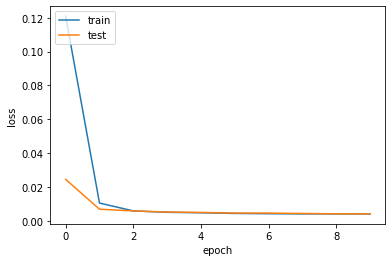

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [112]:
x_pred=x_test[500]
x_pred=np.expand_dims(x_pred,axis=0)
y_pred=model.predict(x_pred)
print(y_pred,"\n\n",y_test[500])

[[-0.6950653  -0.46906036 -0.70024645 -0.8091507   0.03398292 -0.4813664 ]] 

 [-0.68620498 -0.42699027 -0.79974705 -0.8942418   0.03880309 -0.45780118]
